# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter = ';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter = ';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.shape

(891221, 85)

In [4]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [6]:
azdias.columns

Index(['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GEBURTSJAHR', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN',
       'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE',
       'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT',
       'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT',
       'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP',
       'ALTER_HH', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE',
       'KK_KUNDENTYP', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_

In [7]:
feat_info.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,SEMIO_TRADV,person,ordinal,[-1]
freq,1,43,49,26


In [8]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [9]:
missing = azdias.isnull().sum()
print(missing.sum())

4896838


In [10]:
print(azdias.shape[1])

85


In [11]:
# Identify missing or unknown data values and convert them to NaNs.
for column in range(azdias.shape[1]):
    column_name=azdias.columns[column]
    na_list=feat_info.iloc[column,3]
    na_list=na_list.replace('[', '')
    na_list=na_list.replace(']', '')
    na_list=na_list.split(',')
    if na_list == ['']:
        continue
    else:
        for na_code in na_list:
            if azdias[column_name].dtype =='object':
                azdias.loc[azdias[column_name]==na_code,column_name]=np.nan 
            else:   
                na_code=int(na_code)
                azdias.loc[azdias[column_name]==na_code,column_name]=np.nan


In [12]:
azdias.head(10)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3.0,1.0,2.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,NaN,2.0,2.0,5.0,1.0,5.0,1.0,5.0,4.0,3.0,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,NaN,1.0,1.0,3.0,3.0,3.0,4.0,1.0,3.0,2.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,NaN,3.0,1.0,3.0,4.0,4.0,2.0,4.0,2.0,2.0,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,NaN,3.0,2.0,4.0,2.0,4.0,2.0,3.0,5.0,4.0,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [13]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
nan_count = azdias.isnull().sum()
print(nan_count)

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [14]:
# Investigate patterns in the amount of missing data in each column.
total_rows = azdias.shape[0]
percentage_nan = (nan_count/total_rows)*100
print(percentage_nan)


AGER_TYP                 76.955435
ALTERSKATEGORIE_GROB      0.323264
ANREDE_KZ                 0.000000
CJT_GESAMTTYP             0.544646
FINANZ_MINIMALIST         0.000000
FINANZ_SPARER             0.000000
FINANZ_VORSORGER          0.000000
FINANZ_ANLEGER            0.000000
FINANZ_UNAUFFAELLIGER     0.000000
FINANZ_HAUSBAUER          0.000000
FINANZTYP                 0.000000
GEBURTSJAHR              44.020282
GFK_URLAUBERTYP           0.544646
GREEN_AVANTGARDE          0.000000
HEALTH_TYP               12.476816
LP_LEBENSPHASE_FEIN      10.954859
LP_LEBENSPHASE_GROB      10.611509
LP_FAMILIE_FEIN           8.728699
LP_FAMILIE_GROB           8.728699
LP_STATUS_FEIN            0.544646
LP_STATUS_GROB            0.544646
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
RETOURTYP_BK_S            0.544646
SEMIO_SOZ                 0.000000
SEMIO_FAM                 0.000000
SEMIO_REL                 0.000000
SEMIO_MAT                 0.000000
SEMIO_VERT          

In [15]:
#Number of features with no missing data
count = 0
for i in percentage_nan:
    if i == 0:
        count = count + 1
print('Number of features without any missing data: {}' .format(count))

Number of features without any missing data: 24


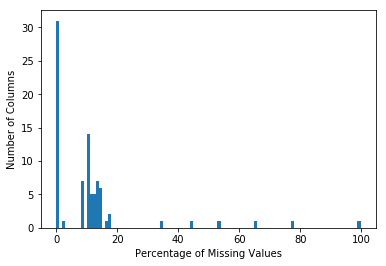

In [16]:
plt.hist(percentage_nan, bins=100)
plt.ylabel('Number of Columns')
plt.xlabel('Percentage of Missing Values')
plt.show()

In [17]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
twenty_percent_nan = percentage_nan[percentage_nan>20]
print(len(twenty_percent_nan))
print(twenty_percent_nan)


6
AGER_TYP        76.955435
GEBURTSJAHR     44.020282
TITEL_KZ        99.757636
ALTER_HH        34.813699
KK_KUNDENTYP    65.596749
KBA05_BAUMAX    53.468668
dtype: float64


In [18]:
columns_to_drop = twenty_percent_nan.index.tolist()
azdias = azdias.drop(columns_to_drop, axis=1)
azdias.head()


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [19]:
print(len(azdias.columns))

79


#### Discussion 1.1.2: Assess Missing Data in Each Column

Only 5 columns in the dataset has missing values more than 20%. And also these five columns have far higher missing data percentage and hence might not contribute much to the learning algorithms. So, these columns were considered as outliers and dropped for further analyis.

We have 24 columns with no missing data. And from the histogram, we get around 20 columns might have lesser than 10% missing data.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [20]:
# How much data is missing in each row of the dataset?
print(sum(azdias.isnull().any(axis=1)))


268012


There are 268012 rows with atleast one missing value in it. Almost one third of the rows have atleast one missing data in it.

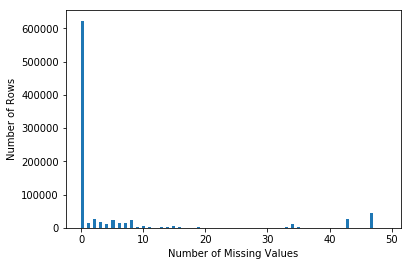

In [21]:
missing_per_row =azdias.isnull().sum(axis=1)
plt.hist(missing_per_row, bins=100)
plt.ylabel('Number of Rows')
plt.xlabel('Number of Missing Values')
plt.show()

In [22]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
#since rows missing more than 10 values are ver less, we keep the cut-off as 10
missing_lt_10 = azdias[azdias.isnull().sum(axis=1) <= 10].reset_index(drop=True)
missing_gt_10 = azdias[azdias.isnull().sum(axis=1) > 10].reset_index(drop=True)

print('Number of rows with less than or equal to 10 missing values {}'.format(len(missing_lt_10)))
print('Number of rows with greater than 10 missing values {}'.format(len(missing_gt_10)))

Number of rows with less than or equal to 10 missing values 780153
Number of rows with greater than 10 missing values 111068


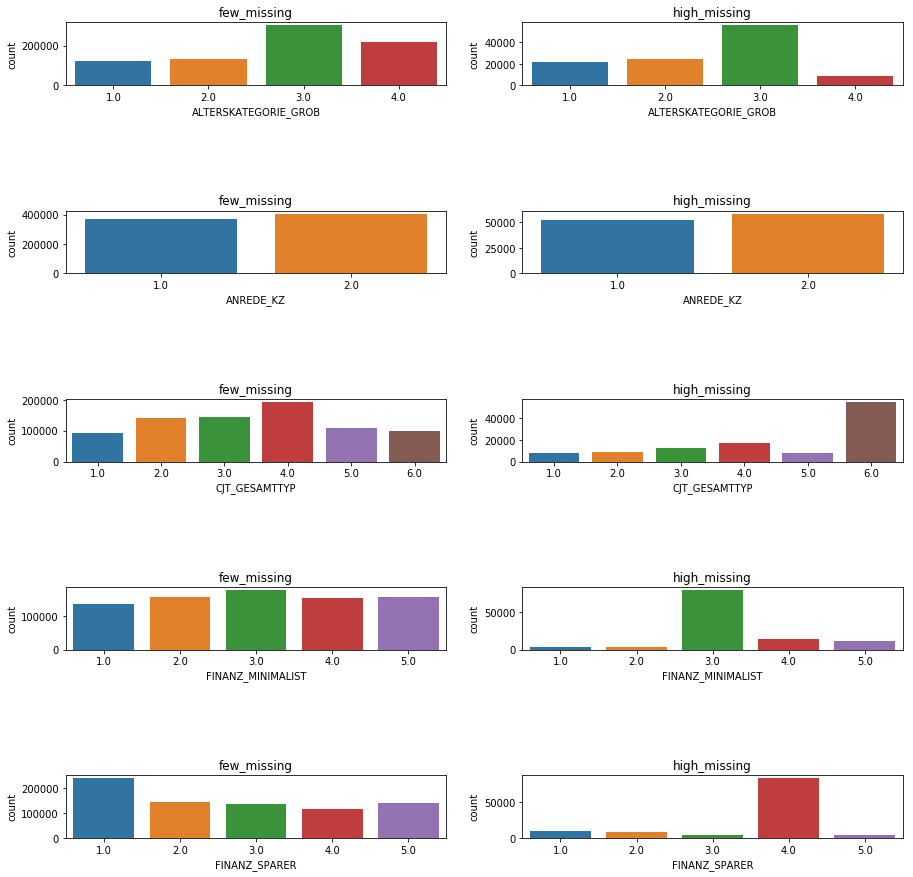

In [23]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
col_missing_lt_10 = missing_lt_10.columns

fig, axs = plt.subplots(5,2, figsize=(15, 15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace =2 , wspace=.2)
axs = axs.ravel()

for i in range(5):
    
    sns.countplot(missing_lt_10[col_missing_lt_10[i]], ax=axs[i*2])
    axs[i*2].set_title('few_missing')
        
    sns.countplot(missing_gt_10[col_missing_lt_10[i]], ax=axs[i*2+1])
    axs[i*2+1].set_title('high_missing')


In [25]:
print(len(missing_lt_10.columns))

79


# Discussion 1.1.3: Assess Missing Data in Each Row

1. From the histogram Number of missing values vs. the number of rows, we get that there are more than 600k rows with 0 or 1 missing values. And more than 90% of the rows have less than 10 missing values. (out of the 85 features).

2. Number of rows with less than or equal to 10 missing values 780153
   Number of rows with greater than 10 missing values 111068
   So, I have removed the rows with more than 10 missing values to consider only informative rows.
   So, I will be using the missing_lt_10 dataframe for the further computation.
   
3. The observations of the distribution of missing values among the two subsets are as follows,

a. The distribution of missing value rows according to age is propotionately similar for missing_lt_10 and missing_gt_10. i.e. rows with value 3.0 (46-60 years old) for age is missing the highest among other age groups.
b. The same hold for gender too. This implies that there is no bias in missing data based on gender.
c. We observe a large number of rows with more than 10 missing data for a specific type of customer journey typology.
Advertising-Enthusiast with restricted Cross-Channel-Behaviour, although it stays pretty low for missing_lt_10.
d. Distribution of missing value rows based for minimalist is almost similar.
e. For very high financial sparer(second level in spending), we see a very few data points missing when compared to other values. There is a huge spike in the number of high missing data rows for low financial sparer.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [26]:
# How many features are there of each data type?
feat_info.groupby('type').count()


,attribute,information_level,missing_or_unknown
type,,,
categorical,21,21,21
interval,1,1,1
mixed,7,7,7
numeric,7,7,7
ordinal,49,49,49


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [27]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
cat_columns = feat_info.loc[feat_info['type'] == 'categorical', 'attribute'].values
print(len(cat_columns))
print(cat_columns)

21
['AGER_TYP' 'ANREDE_KZ' 'CJT_GESAMTTYP' 'FINANZTYP' 'GFK_URLAUBERTYP'
 'GREEN_AVANTGARDE' 'LP_FAMILIE_FEIN' 'LP_FAMILIE_GROB' 'LP_STATUS_FEIN'
 'LP_STATUS_GROB' 'NATIONALITAET_KZ' 'SHOPPER_TYP' 'SOHO_KZ' 'TITEL_KZ'
 'VERS_TYP' 'ZABEOTYP' 'KK_KUNDENTYP' 'GEBAEUDETYP' 'OST_WEST_KZ'
 'CAMEO_DEUG_2015' 'CAMEO_DEU_2015']


In [28]:
#Removing AGER_TYPE, TITEL_KZ, KK_KUNDENTYP from cat_columns as it was already removed from our dataframe missing_lt_5 during dropping
#of collumns having more than 20% missing values
index = [0, 13, 16]
cat_columns = np.delete(cat_columns, index)

In [29]:
print(len(cat_columns))

18


In [30]:
col_binary = []
col_multi = []
for column in cat_columns:
    if (len(missing_lt_10[column].unique())==2):
        col_binary.append(column)
    elif (len(missing_lt_10[column].unique())>2):
        col_multi.append(column)

In [31]:
for c in col_binary:
    print(missing_lt_10[c].value_counts())

2.0    406643
1.0    373510
Name: ANREDE_KZ, dtype: int64
0    608462
1    171691
Name: GREEN_AVANTGARDE, dtype: int64
0.0    773607
1.0      6546
Name: SOHO_KZ, dtype: int64
W    614719
O    165434
Name: OST_WEST_KZ, dtype: int64


In [32]:
# Re-encode categorical variable(s) to be kept in the analysis.
missing_lt_10['ANREDE_KZ'].replace([2,1], [1,0], inplace=True)
missing_lt_10['VERS_TYP'].replace([2.0,1.0], [1,0], inplace=True)
missing_lt_10['OST_WEST_KZ'].replace(['W','O'], [1,0], inplace=True)
print(len(missing_lt_10.columns))

79


In [33]:
for c in col_binary:
    print(missing_lt_10[c].value_counts())

1.0    406643
0.0    373510
Name: ANREDE_KZ, dtype: int64
0    608462
1    171691
Name: GREEN_AVANTGARDE, dtype: int64
0.0    773607
1.0      6546
Name: SOHO_KZ, dtype: int64
1    614719
0    165434
Name: OST_WEST_KZ, dtype: int64


In [34]:
print(len(col_multi))

14


In [35]:
# Drop multi-level features
for feature in col_multi:
    missing_lt_10=missing_lt_10.drop(feature, axis=1)

In [36]:
print(missing_lt_10.shape)

(780153, 65)


#### Discussion 1.2.1: Re-Encode Categorical Features

The binary categorical columns were encoded into [0,1] for further computations.
I removed all the multi-level features.
The shape of the dataframe at this point is (780153, 65)

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [37]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
missing_lt_10['PRAEGENDE_JUGENDJAHRE'].value_counts()

# create first new varibale: 'WHETHER_MAINSTREAM'
missing_lt_10.loc[missing_lt_10['PRAEGENDE_JUGENDJAHRE'].isin([1,3,5,8,10,12,14]),'WHETHER_MAINSTREAM']=1
missing_lt_10.loc[missing_lt_10['PRAEGENDE_JUGENDJAHRE'].isin([2,4,6,7,9,11,13,15]),'WHETHER_MAINSTREAM']=2

# create second new varibale: 'Region': East-1, West-2, EAST+WEST-3
missing_lt_10.loc[missing_lt_10['PRAEGENDE_JUGENDJAHRE'].isin([7,12,13]),'REGION']=1
missing_lt_10.loc[missing_lt_10['PRAEGENDE_JUGENDJAHRE'].isin([6,10,11]),'REGION']=2
missing_lt_10.loc[missing_lt_10['PRAEGENDE_JUGENDJAHRE'].isin([1,2,3,4,5,8,9,14,15]),'REGION']=3

# drop original column
missing_lt_10=missing_lt_10.drop('PRAEGENDE_JUGENDJAHRE',axis=1)

In [38]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
missing_lt_10['CAMEO_INTL_2015'].value_counts()
missing_lt_10['CAMEO_INTL_2015']=missing_lt_10['CAMEO_INTL_2015'].astype(float)

# create first new varibale: 'HOUSEHOLD_WEALTH'
missing_lt_10.loc[missing_lt_10['CAMEO_INTL_2015'].isin([51,52,53,54,55]),'HOUSEHOLD_WEALTH']=1
missing_lt_10.loc[missing_lt_10['CAMEO_INTL_2015'].isin([41,42,43,44,45]),'HOUSEHOLD_WEALTH']=2
missing_lt_10.loc[missing_lt_10['CAMEO_INTL_2015'].isin([31,32,33,34,35]),'HOUSEHOLD_WEALTH']=3
missing_lt_10.loc[missing_lt_10['CAMEO_INTL_2015'].isin([21,22,23,24,25]),'HOUSEHOLD_WEALTH']=4
missing_lt_10.loc[missing_lt_10['CAMEO_INTL_2015'].isin([11,12,13,14,15]),'HOUSEHOLD_WEALTH']=5

# create second new varibale: 'HOUSEHOLD_LIFE_STAGE'
missing_lt_10.loc[missing_lt_10['CAMEO_INTL_2015'].isin([11,21,31,41,51]),'HOUSEHOLD_LIFE_STAGE']=1
missing_lt_10.loc[missing_lt_10['CAMEO_INTL_2015'].isin([12,22,32,42,52]),'HOUSEHOLD_LIFE_STAGE']=2
missing_lt_10.loc[missing_lt_10['CAMEO_INTL_2015'].isin([13,23,33,43,53]),'HOUSEHOLD_LIFE_STAGE']=3
missing_lt_10.loc[missing_lt_10['CAMEO_INTL_2015'].isin([14,24,34,44,54]),'HOUSEHOLD_LIFE_STAGE']=4
missing_lt_10.loc[missing_lt_10['CAMEO_INTL_2015'].isin([15,25,35,45,55]),'HOUSEHOLD_LIFE_STAGE']=5


# drop original column
missing_lt_10=missing_lt_10.drop('CAMEO_INTL_2015',axis=1)


In [40]:
print(len(missing_lt_10.columns))

67


#### Discussion 1.2.2: Engineer Mixed-Type Features

For variable 'PRAEGENDE_JUGENDJAHRE'
1. I have encoded the dimension whether the person is an avantgarde or mainstream into the variable whether_mainstream which has two values 1(that it is mainstream) and 2 (when it is avantgrade).
2. I have encoded the dimension whether the person moved to east (1), west(2), or east-west(3).

I have removed the original column 'PRAEGENDE_JUGENDJAHRE' from azdias

For variable 'CAMEO_INTL_2015'
1. I have encoded the wealthiness level of the person into the variable HOUSEHOLD_WEALTH which has five possible values 1 to 5 (in decreasing order of wealthiness, 1 - wealthy and 5 - poorer)
2. I have encoded the life stage of the person's household into the variable HOUSEHOLD_LIFE_STAGE which has five possible values 1 to 5 (increasing order of maturity 1 - Pre-family couples and 5 - Elders)

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [41]:
print(missing_lt_10.shape)
#this is the dataframe that we are going to do analysis with.

(780153, 67)


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [42]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for col in range(df.shape[1]):
        col_name=df.columns[col]
        na_list=feat_info.iloc[col,3]
        na_list=na_list.replace('[', '')
        na_list=na_list.replace(']', '')
        na_list=na_list.split(',')
        if na_list == ['']:
            continue
        else:
            for na_code in na_list:
                if df[col_name].dtype =='object':
                    df.loc[df[col_name]==na_code,col_name]=np.nan 
                else:   
                    na_code=int(na_code)
                    df.loc[df[col_name]==na_code,col_name]=np.nan 
    
    # Dropping the columns that we have removed as it contained more than twenty percent missing values
    df = df.drop(columns_to_drop, axis=1)
    
    #Dropping the columns with multi-level features
    df = df.drop(col_multi, axis=1)
    
    #Considering only the rows that has less than or equal to 10 missing values. (neglecting the others)
    df = df[df.isnull().sum(axis=1) <= 10].reset_index(drop=True)
    
   # select, re-encode, and engineer column values.
    df['ANREDE_KZ'].replace([2,1], [1,0], inplace=True)
    df['OST_WEST_KZ'].replace(['W','O'], [1,0], inplace=True)
    
    df['PRAEGENDE_JUGENDJAHRE'].value_counts()
    # create first new varibale: 'WHETHER_MAINSTREAM'
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([1,3,5,8,10,12,14]),'WHETHER_MAINSTREAM']=1
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([2,4,6,7,9,11,13,15]),'WHETHER_MAINSTREAM']=2
    # create second new varibale: 'Region': East-1, West-2, EAST+WEST-3
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([7,12,13]),'REGION']=1
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([6,10,11]),'REGION']=2
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([1,2,3,4,5,8,9,14,15]),'REGION']=3
    # drop original column
    df=df.drop('PRAEGENDE_JUGENDJAHRE',axis=1)
    
    
    df['CAMEO_INTL_2015'].value_counts()
    df['CAMEO_INTL_2015']=df['CAMEO_INTL_2015'].astype(float)
    # create first new varibale: 'HOUSEHOLD_WEALTH'
    df.loc[df['CAMEO_INTL_2015'].isin([51,52,53,54,55]),'HOUSEHOLD_WEALTH']=1
    df.loc[df['CAMEO_INTL_2015'].isin([41,42,43,44,45]),'HOUSEHOLD_WEALTH']=2
    df.loc[df['CAMEO_INTL_2015'].isin([31,32,33,34,35]),'HOUSEHOLD_WEALTH']=3
    df.loc[df['CAMEO_INTL_2015'].isin([21,22,23,24,25]),'HOUSEHOLD_WEALTH']=4
    df.loc[df['CAMEO_INTL_2015'].isin([11,12,13,14,15]),'HOUSEHOLD_WEALTH']=5
    # create second new varibale: 'HOUSEHOLD_LIFE_STAGE'
    df.loc[df['CAMEO_INTL_2015'].isin([11,21,31,41,51]),'HOUSEHOLD_LIFE_STAGE']=1
    df.loc[df['CAMEO_INTL_2015'].isin([12,22,32,42,52]),'HOUSEHOLD_LIFE_STAGE']=2
    df.loc[df['CAMEO_INTL_2015'].isin([13,23,33,43,53]),'HOUSEHOLD_LIFE_STAGE']=3
    df.loc[df['CAMEO_INTL_2015'].isin([14,24,34,44,54]),'HOUSEHOLD_LIFE_STAGE']=4
    df.loc[df['CAMEO_INTL_2015'].isin([15,25,35,45,55]),'HOUSEHOLD_LIFE_STAGE']=5
    # drop original column
    df=df.drop('CAMEO_INTL_2015',axis=1)
    
    return df
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [49]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
from sklearn.preprocessing import Imputer
fill_missing = Imputer(strategy='most_frequent')
missing_lt_10_imputed = pd.DataFrame(fill_missing.fit_transform(missing_lt_10))

In [50]:
print(missing_lt_10.shape)
print(missing_lt_10_imputed.shape)

(780153, 67)
(780153, 67)


In [51]:
missing_lt_10.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,WHETHER_MAINSTREAM,REGION,HOUSEHOLD_WEALTH,HOUSEHOLD_LIFE_STAGE
0,1.0,1.0,1.0,5.0,2.0,5.0,4.0,5.0,0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,1.0,3.0,1.0,1.0
1,3.0,1.0,1.0,4.0,1.0,2.0,3.0,5.0,1,3.0,...,1.0,4.0,4.0,3.0,5.0,2.0,2.0,3.0,4.0,4.0
2,4.0,1.0,4.0,2.0,5.0,2.0,1.0,2.0,0,2.0,...,1.0,3.0,4.0,2.0,3.0,3.0,1.0,3.0,5.0,2.0
3,3.0,0.0,4.0,3.0,4.0,1.0,3.0,2.0,0,3.0,...,2.0,3.0,3.0,4.0,6.0,5.0,1.0,3.0,2.0,3.0
4,1.0,1.0,3.0,1.0,5.0,2.0,2.0,5.0,0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,1.0,3.0,1.0,4.0


In [52]:
missing_lt_10_imputed.head()

,0,1,2,3,4,5,6,7,8,9,...,57,58,59,60,61,62,63,64,65,66
0,1.0,1.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,1.0,3.0,1.0,1.0
1,3.0,1.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,...,1.0,4.0,4.0,3.0,5.0,2.0,2.0,3.0,4.0,4.0
2,4.0,1.0,4.0,2.0,5.0,2.0,1.0,2.0,0.0,2.0,...,1.0,3.0,4.0,2.0,3.0,3.0,1.0,3.0,5.0,2.0
3,3.0,0.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,...,2.0,3.0,3.0,4.0,6.0,5.0,1.0,3.0,2.0,3.0
4,1.0,1.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,1.0,3.0,1.0,4.0


In [53]:
missing_lt_10_imputed.columns = missing_lt_10.columns
missing_lt_10_imputed.index = missing_lt_10.index

In [54]:
missing_lt_10_imputed.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,WHETHER_MAINSTREAM,REGION,HOUSEHOLD_WEALTH,HOUSEHOLD_LIFE_STAGE
0,1.0,1.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,1.0,3.0,1.0,1.0
1,3.0,1.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,...,1.0,4.0,4.0,3.0,5.0,2.0,2.0,3.0,4.0,4.0
2,4.0,1.0,4.0,2.0,5.0,2.0,1.0,2.0,0.0,2.0,...,1.0,3.0,4.0,2.0,3.0,3.0,1.0,3.0,5.0,2.0
3,3.0,0.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,...,2.0,3.0,3.0,4.0,6.0,5.0,1.0,3.0,2.0,3.0
4,1.0,1.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,1.0,3.0,1.0,4.0


In [55]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
missing_lt_10_imputed_scaled = scaler.fit_transform(missing_lt_10_imputed)

In [56]:
missing_lt_10_imputed_scaled = pd.DataFrame(missing_lt_10_imputed_scaled, columns=list(missing_lt_10_imputed))

In [57]:
type(missing_lt_10_imputed_scaled)

pandas.core.frame.DataFrame

### Discussion 2.1: Apply Feature Scaling

All the missing values in the dataframe missing_lt_5 were replaced with the most frequent value(mode) in that column and stored in the dataframe missing_lt_5_imputed. 
Using StandardScaler() of sklearn, all the features are scaled in order to give an equal importance to all the features in the dataframe during analysis. The final dataframe is missing_lt_5_imputed_scaled.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [58]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(missing_lt_10_imputed_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

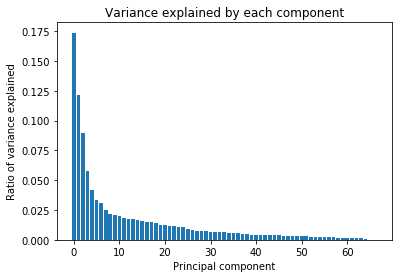

In [59]:
# Investigate the variance accounted for by each principal component.
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
plt.title("Variance explained by each component")
plt.xlabel("Principal component")
plt.ylabel("Ratio of variance explained")
plt.show()


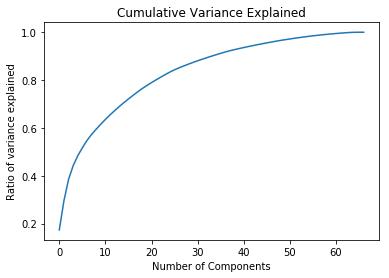

In [60]:
plt.plot(range(len(pca.explained_variance_ratio_)),np.cumsum(pca.explained_variance_ratio_), '-')
plt.title("Cumulative Variance Explained")
plt.xlabel("Number of Components")
plt.ylabel("Ratio of variance explained")
plt.show()

In [61]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_for_25 = PCA(n_components=25)
azdias_pca = pca_for_25.fit_transform(missing_lt_10_imputed_scaled)


### Discussion 2.2: Perform Dimensionality Reduction

I am retaining 25 principal components because collectively it explains more than 80% of the variances while reducing  the number of features by more than 65%.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [62]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def pca_weights(pca, i):
    pca_weights_df = pd.DataFrame(pca.components_, columns=list(missing_lt_10_imputed_scaled.columns))
    weights = pca_weights_df.iloc[i].sort_values(ascending=False)
    return weights


In [63]:
pca_weight_0 = pca_weights(pca_for_25, 0)
print (pca_weight_0)

PLZ8_ANTG3               0.227721
PLZ8_ANTG4               0.220761
PLZ8_BAUMAX              0.216682
ORTSGR_KLS9              0.200085
HH_EINKOMMEN_SCORE       0.198541
EWDICHTE                 0.197511
FINANZ_HAUSBAUER         0.168485
PLZ8_ANTG2               0.154723
KBA05_ANTG4              0.154409
ARBEIT                   0.143424
ANZ_HAUSHALTE_AKTIV      0.136280
RELAT_AB                 0.135464
KBA05_ANTG3              0.134439
FINANZ_SPARER            0.107793
SEMIO_PFLICHT            0.079634
SEMIO_REL                0.076832
SEMIO_RAT                0.065608
W_KEIT_KIND_HH           0.064227
SEMIO_MAT                0.057500
REGIOTYP                 0.056003
SEMIO_FAM                0.055835
SEMIO_TRADV              0.054467
SEMIO_KAEM               0.045669
SEMIO_KULT               0.044254
FINANZ_UNAUFFAELLIGER    0.043138
PLZ8_HHZ                 0.042203
ANZ_HH_TITEL             0.036156
FINANZ_ANLEGER           0.035706
KKK                      0.033518
SEMIO_SOZ     

In [64]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_weight_1 = pca_weights(pca_for_25, 1)
print (pca_weight_1)


ALTERSKATEGORIE_GROB     0.279454
SEMIO_ERL                0.260288
FINANZ_VORSORGER         0.242444
SEMIO_LUST               0.193466
RETOURTYP_BK_S           0.159102
SEMIO_KRIT               0.137998
SEMIO_KAEM               0.131828
ANREDE_KZ                0.116619
W_KEIT_KIND_HH           0.101969
FINANZ_MINIMALIST        0.092221
SEMIO_DOM                0.090809
FINANZ_HAUSBAUER         0.089688
WOHNDAUER_2008           0.065860
EWDICHTE                 0.059980
ORTSGR_KLS9              0.058597
PLZ8_ANTG3               0.054701
PLZ8_ANTG4               0.051404
PLZ8_BAUMAX              0.046911
KBA05_ANTG4              0.043323
RELAT_AB                 0.041392
ARBEIT                   0.041245
PLZ8_ANTG2               0.038333
ANZ_HAUSHALTE_AKTIV      0.037631
REGION                   0.032352
ANZ_HH_TITEL             0.024883
HOUSEHOLD_LIFE_STAGE     0.023646
KBA05_ANTG3              0.020909
HH_EINKOMMEN_SCORE       0.019285
ANZ_TITEL                0.007363
PLZ8_HHZ      

In [65]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_weight_2 = pca_weights(pca_for_25, 2)
print (pca_weight_2)


SEMIO_VERT               0.343130
SEMIO_SOZ                0.252001
SEMIO_FAM                0.227139
SEMIO_KULT               0.207720
FINANZ_MINIMALIST        0.175049
FINANZ_VORSORGER         0.124383
RETOURTYP_BK_S           0.123966
ALTERSKATEGORIE_GROB     0.110898
W_KEIT_KIND_HH           0.086929
SEMIO_LUST               0.086274
GREEN_AVANTGARDE         0.062680
WHETHER_MAINSTREAM       0.062680
ORTSGR_KLS9              0.053742
EWDICHTE                 0.052802
PLZ8_BAUMAX              0.050271
PLZ8_ANTG4               0.048162
PLZ8_ANTG3               0.047713
WOHNDAUER_2008           0.041712
SEMIO_REL                0.037012
ARBEIT                   0.036386
RELAT_AB                 0.034268
SEMIO_MAT                0.033757
PLZ8_ANTG2               0.031858
KBA05_ANTG4              0.027466
ANZ_HAUSHALTE_AKTIV      0.023945
ANZ_HH_TITEL             0.015339
LP_LEBENSPHASE_FEIN      0.011749
ANZ_TITEL                0.011657
LP_LEBENSPHASE_GROB      0.005673
PLZ8_HHZ      

### Discussion 2.3: Interpret Principal Components

Analysing the first component we can make the following observations,

1. PLZ8_ANTG3 (6-10 family houses) and PLZ8_ANTG4 (10+ family houses) have a positive correlation. Each of the factor tends to increase together.
2. You can notice that FINANZ_HAUSBAUER (home ownership) and FINANZ_MINIMALIST (low financial interest) have a negative correlation. 
3. Similarly, ORTSGR_KLS9 (number of inhabitants in increasing order) and HH_EINKOMMEN_SCORE (Estimated household net income in decreasing order i.e. 1 -  highest income and 6 - very low income) have a positive correelation.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [66]:
from sklearn.cluster import KMeans

def k_means(azdias_pca, n_cluster):
    kmeans = KMeans(n_clusters = n_cluster)
    model = kmeans.fit(azdias_pca)
    score = np.abs(model.score(azdias_pca))
    return score

In [67]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...
# compute the average within-cluster distances.
scores = []
scores.append(k_means(azdias_pca, 1))
scores.append(k_means(azdias_pca, 2))
scores.append(k_means(azdias_pca, 3))
print(scores)

[43578576.059235215, 36745217.256533086, 33857621.631935507]


In [68]:
scores.append(k_means(azdias_pca, 4))
scores.append(k_means(azdias_pca, 5))
scores.append(k_means(azdias_pca, 6))
print(scores)

[43578576.059235215, 36745217.256533086, 33857621.631935507, 31830626.839470863, 30390845.942334846, 29121741.075923074]


In [69]:
scores.append(k_means(azdias_pca, 7))
scores.append(k_means(azdias_pca, 8))
scores.append(k_means(azdias_pca, 9))
print(scores)

[43578576.059235215, 36745217.256533086, 33857621.631935507, 31830626.839470863, 30390845.942334846, 29121741.075923074, 28110739.175104011, 27264935.922370698, 26551249.611499783]


In [70]:
scores.append(k_means(azdias_pca, 10))
scores.append(k_means(azdias_pca, 11))
scores.append(k_means(azdias_pca, 12))
print(scores)

[43578576.059235215, 36745217.256533086, 33857621.631935507, 31830626.839470863, 30390845.942334846, 29121741.075923074, 28110739.175104011, 27264935.922370698, 26551249.611499783, 25961441.807383291, 25220409.846730605, 24805568.974996172]


In [71]:
scores.append(k_means(azdias_pca, 13))
scores.append(k_means(azdias_pca, 14))
scores.append(k_means(azdias_pca, 15))
print(scores)

[43578576.059235215, 36745217.256533086, 33857621.631935507, 31830626.839470863, 30390845.942334846, 29121741.075923074, 28110739.175104011, 27264935.922370698, 26551249.611499783, 25961441.807383291, 25220409.846730605, 24805568.974996172, 24394485.155910544, 24069526.956911746, 23765980.120662823]


In [72]:
scores.append(k_means(azdias_pca, 16))
scores.append(k_means(azdias_pca, 17))
scores.append(k_means(azdias_pca, 18))
print(scores)

[43578576.059235215, 36745217.256533086, 33857621.631935507, 31830626.839470863, 30390845.942334846, 29121741.075923074, 28110739.175104011, 27264935.922370698, 26551249.611499783, 25961441.807383291, 25220409.846730605, 24805568.974996172, 24394485.155910544, 24069526.956911746, 23765980.120662823, 23528470.315153968, 23307973.011970825, 22689428.315831147]


Text(0,0.5,'Avg. distance to Cluster center')

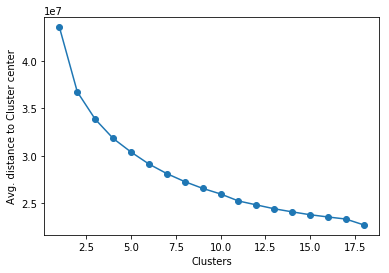

In [73]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
ks = list(range(1,19))
plt.plot(ks, scores, linestyle='-', marker='o')
plt.xlabel('Clusters')
plt.ylabel('Avg. distance to Cluster center')

In [84]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters = 14)
kmeans_14_model = kmeans.fit(azdias_pca)
azdias_pred = kmeans_14_model.predict(azdias_pca)


### Discussion 3.1: Apply Clustering to General Population

From the graph, we can deduce that the elbow point is at N=14 clusters.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [76]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
customers.shape

(191652, 85)

In [77]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_cleaned = clean_data(customers)
print(customers_cleaned.shape)

(139566, 67)


In [78]:
customers_cleaned_imputed = pd.DataFrame(fill_missing.transform(customers_cleaned))
customers_cleaned_imputed.columns = customers_cleaned.columns
customers_cleaned_imputed.index = customers_cleaned.index

In [79]:
print(customers_cleaned_imputed.shape)

(139566, 67)


In [80]:
#Applying Scaler
customers_cleaned_imputed_scaled = scaler.transform(customers_cleaned_imputed)
customers_cleaned_imputed_scaled = pd.DataFrame(customers_cleaned_imputed_scaled, columns=list(customers_cleaned))

In [81]:
#Applying PCA transformation
customers_pca = pca_for_25.transform(customers_cleaned_imputed_scaled)

In [82]:
#Prediction using K-Means 
customers_predict = kmeans_14_model.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

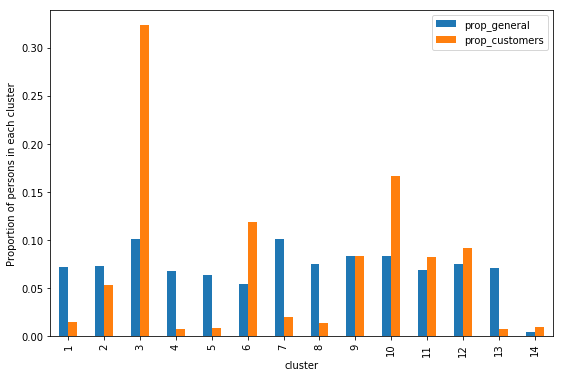

In [83]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
general_proportion = []
customers_proportion = []
x = [i+1 for i in range(14)]
for i in range(14):
    general_proportion.append((azdias_pred == i).sum()/len(azdias_pred))
    customers_proportion.append((customers_predict == i).sum()/len(customers_predict))


df_general = pd.DataFrame({'cluster' : x, 'prop_general' : general_proportion, 'prop_customers':customers_proportion})
df_general.plot(x='cluster', y = ['prop_general', 'prop_customers'], kind='bar', figsize=(9,6))
plt.ylabel('Proportion of persons in each cluster')
plt.show()

In [85]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
cluster_3 = scaler.inverse_transform(pca_for_25.inverse_transform(kmeans_14_model.cluster_centers_[3]))
overrepresented = pd.Series(data = cluster_3, index = customers_cleaned.columns)

In [86]:
print(overrepresented)

ALTERSKATEGORIE_GROB       3.366988
ANREDE_KZ                  0.951271
FINANZ_MINIMALIST          4.078985
FINANZ_SPARER              1.694949
FINANZ_VORSORGER           4.156775
FINANZ_ANLEGER             2.166126
FINANZ_UNAUFFAELLIGER      2.236946
FINANZ_HAUSBAUER           2.413534
GREEN_AVANTGARDE           0.955565
HEALTH_TYP                 2.151078
LP_LEBENSPHASE_FEIN       24.072928
LP_LEBENSPHASE_GROB        7.041838
RETOURTYP_BK_S             3.545399
SEMIO_SOZ                  2.859193
SEMIO_FAM                  2.047721
SEMIO_REL                  2.177000
SEMIO_MAT                  2.412949
SEMIO_VERT                 3.079891
SEMIO_LUST                 5.182019
SEMIO_ERL                  6.226535
SEMIO_KULT                 2.027315
SEMIO_RAT                  3.625393
SEMIO_KRIT                 5.663202
SEMIO_DOM                  6.133709
SEMIO_KAEM                 5.848941
SEMIO_PFLICHT              3.092307
SEMIO_TRADV                2.925054
SOHO_KZ                    0

In [87]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
cluster_8 = scaler.inverse_transform(pca_for_25.inverse_transform(kmeans_14_model.cluster_centers_[8]))
underrepresented = pd.Series(data = cluster_8, index = customers_cleaned.columns)
print(underrepresented)

ALTERSKATEGORIE_GROB       1.654255
ANREDE_KZ                  0.994926
FINANZ_MINIMALIST          2.271615
FINANZ_SPARER              4.013486
FINANZ_VORSORGER           2.243308
FINANZ_ANLEGER             4.458060
FINANZ_UNAUFFAELLIGER      3.898449
FINANZ_HAUSBAUER           2.905631
GREEN_AVANTGARDE           0.173827
HEALTH_TYP                 2.270767
LP_LEBENSPHASE_FEIN       16.582338
LP_LEBENSPHASE_GROB        5.228236
RETOURTYP_BK_S             2.427373
SEMIO_SOZ                  2.962559
SEMIO_FAM                  3.791483
SEMIO_REL                  5.386173
SEMIO_MAT                  5.148524
SEMIO_VERT                 2.487816
SEMIO_LUST                 3.041168
SEMIO_ERL                  4.266515
SEMIO_KULT                 4.126322
SEMIO_RAT                  6.303607
SEMIO_KRIT                 5.407506
SEMIO_DOM                  5.956415
SEMIO_KAEM                 5.645209
SEMIO_PFLICHT              6.252148
SEMIO_TRADV                5.844967
SOHO_KZ                    0

### Discussion 3.3: Compare Customer Data to Demographics Data

From the above analysis we have the following observations,

Cluster 8 is overrepresented in the customer data compared to general population data. A few of its characteristics of the people that are relatively popular with the mail order company are,
1. ALTERSKATEGORIE_GROB (3.36) - 46 - 60 years old.
2. LP_LEBENSPHASE_FEIN(24.04) - low-income earner families.
3. FINANZ_SPARER (1.67) - very high money saver.
4. ORTSGR_KLS9 (5.49) - 20,001 to  50,000 inhabitants in the community.


Cluster 13 is underrepresented in the customer data compared to general population data. A few of its characteristics of the people who are relatively unpopular with the mail order company are,
1. ALTERSKATEGORIE_GROB (1.65) - < 30 years old.
2. LP_LEBENSPHASE_FEIN(16.58) - average earner couples of higher age.
3. FINANZ_SPARER (4.03) - low money-saver.
4. ORTSGR_KLS9 (3.96) - 5,001 to  10,000 inhabitants in the community. 

The above show a few of the features that differentiates the charateristics of the general population and the customers data. These differentiates can be used by the company to correctly identify their customer segements.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.